In [109]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os

import myfitnesspal
import browser_cookie3
import datetime
from datetime import timedelta
from whittaker_eilers import WhittakerSmoother
import statsmodels.api as sm

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

In [110]:
current_path = os.path.abspath("")
directory = os.path.dirname(current_path)
results_directory = rf"{directory}\bormhub_results"

In [111]:
client = myfitnesspal.Client(cookiejar = browser_cookie3.firefox())
client.get_date(2025,1,20)

<01/20/25 {'calories': 3456.0, 'carbohydrates': 370.0, 'fat': 129.0, 'protein': 175.0, 'sodium': 4031.0, 'sugar': 98.0}>

In [112]:
days_back = 80
today = datetime.date.today() 
start_date = today - timedelta(days=days_back)

cals = client.get_report("Calories", "nutrition", start_date, today)
net_cals = client.get_report("Net Calories", "nutrition", start_date, today)

In [113]:
cals

OrderedDict([(datetime.date(2024, 11, 20), 2861),
             (datetime.date(2024, 11, 21), 2850),
             (datetime.date(2024, 11, 22), 2933),
             (datetime.date(2024, 11, 23), 2713),
             (datetime.date(2024, 11, 24), 2793),
             (datetime.date(2024, 11, 25), 2832),
             (datetime.date(2024, 11, 26), 2530),
             (datetime.date(2024, 11, 27), 2781),
             (datetime.date(2024, 11, 28), 2613),
             (datetime.date(2024, 11, 29), 2769),
             (datetime.date(2024, 11, 30), 2461),
             (datetime.date(2024, 12, 1), 2775),
             (datetime.date(2024, 12, 2), 2686),
             (datetime.date(2024, 12, 3), 3835),
             (datetime.date(2024, 12, 4), 2414),
             (datetime.date(2024, 12, 5), 2618),
             (datetime.date(2024, 12, 6), 2590),
             (datetime.date(2024, 12, 7), 3058),
             (datetime.date(2024, 12, 8), 2613),
             (datetime.date(2024, 12, 9), 3249),
         

In [114]:
cals_df = pd.DataFrame(cals.values(), index=cals.keys(), columns=['cals'])
net_cals_df = pd.DataFrame(net_cals.values(), index=net_cals.keys(), columns=['net_cals'])

df = pd.concat([cals_df, net_cals_df], axis=1).fillna(0)
def datetime_to_pd_timestamp(datetime): return pd.Timestamp(datetime) 
df.index = df.index.map(datetime_to_pd_timestamp)
df

,cals,net_cals
2024-11-20,2861,2861
2024-11-21,2850,2850
2024-11-22,2933,2675
2024-11-23,2713,2713
2024-11-24,2793,2793
2024-11-25,2832,2550
2024-11-26,2530,2530
2024-11-27,2781,2413
2024-11-28,2613,2613
2024-11-29,2769,2585


In [115]:
# split into empty and non-empty
df_empty = df[df['cals'] == 0]
df = df[df['cals'] != 0]

In [116]:
# import weight data
weight_md_path = rf"{directory}\Notes\Fitness\Body weight.md" 
weight_df = pd.read_csv(weight_md_path, sep=",", header=None)

weight_df[0] = pd.to_datetime(weight_df[0], format="%Y-%m-%d")

weight_df[1] = pd.to_numeric(weight_df[1], errors='coerce')
weight_df = weight_df.rename(columns={0: "date", 1: 'weight'})
weight_df = weight_df.set_index('date')

# weight smoothing

lowess = sm.nonparametric.lowess
w_smoothed_array = lowess(weight_df['weight'], weight_df.index, frac=0.075)
w_smoothed_df = pd.DataFrame(w_smoothed_array, columns=['date','weight_smoothed']).set_index('date')
w_smoothed_df.index = pd.to_datetime( (w_smoothed_df.index).astype(np.int64) )
weight_df = pd.concat([weight_df, w_smoothed_df], axis=1)
weight_df

,weight,weight_smoothed
date,,
2021-02-25,79.8,76.550204
2021-03-25,76.9,75.992813
2021-04-02,75.9,75.842450
2021-04-06,74.0,75.768399
2021-04-13,73.5,75.639882
2021-04-19,74.5,75.530077
2021-04-30,74.0,75.327274
2021-05-12,75.1,75.101880
2021-06-05,75.7,74.651517


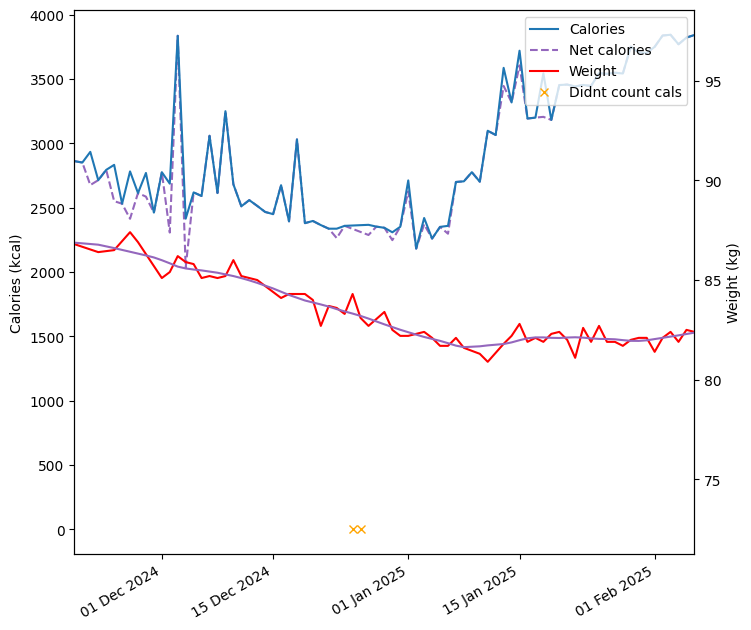

In [117]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ln2 = ax1.plot(df.index,df['net_cals'], linestyle='--', color='tab:purple', label='Net calories')
ln1 = ax1.plot(df.index,df['cals'], label='Calories')
ln3 = ax2.plot(weight_df.index,weight_df['weight'], 'r', label='Weight')
ln4 = ax1.plot(df_empty.index,df_empty['cals'], 'x', color='orange', label='Didnt count cals')
ln5 = ax2.plot(weight_df.index,weight_df['weight_smoothed'], color='tab:purple', label='Weight smoothed')

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

ax1.set_xlim([min(df.index), max(weight_df.index)])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.gcf().autofmt_xdate()

ax1.set_ylabel("Calories (kcal)")
ax2.set_ylabel("Weight (kg)")

plt.savefig(rf'{results_directory}\figures\cals.png', dpi=300, bbox_inches='tight')

In [118]:
# combine calories df and weight df
results = pd.concat([df, weight_df], axis=1)
# crop initial rows before we get calorie data
results = results.loc[results['cals'].first_valid_index():]
# results

In [119]:
# estimate of caloric deficit for 1 kg fat
# https://www.reddit.com/r/loseit/comments/yux3os/1_kg_7000_or_7700_calories/
kcal_per_kg = 7740
print(f"To gain 1 kg/month, eat at {kcal_per_kg/30.43:.1f} kcal surplus")

To gain 1 kg/month, eat at 254.4 kcal surplus


In [120]:
weight_diff_list = pd.Series(name = 'weight_change')
cal_intake_list = pd.Series(name = 'cal_daily_intake')
cal_maintenance_list = pd.Series(name = 'cal_maintenance')
for index, row in results.iterrows():
    weight = row['weight']
    if not np.isnan(weight):
        # find next valid weight
        rest_of_results = results.loc[index:]
        # crop the first row from rest of results
        rest_of_results = rest_of_results.iloc[1:]
        next_weight_index = rest_of_results['weight'].first_valid_index()
        # have to check for none in case this is the final row
        if next_weight_index != None:
            next_weight = results.loc[next_weight_index, 'weight']
            weight_change = (next_weight - weight)
            # add weight_change to our dataframe
            weight_diff_list.loc[index] = weight_change
            # find all calories intaken from between now to the next valid weight
            interim_calories = results['net_cals'].loc[index:next_weight_index]

            days_to_next = len(interim_calories) - 1
            # need to do a check if i missed calorie counting on any of the days to next weight index, and if so skip the rest
            if (next_weight_index - index).days == days_to_next:
                # get rid of last row of interim_calories
                interim_calories = interim_calories.head(days_to_next)
                cal_intake = sum(interim_calories)
                cal_daily_intake = cal_intake / days_to_next
                # add cal_daily_intake to our dataframe
                cal_intake_list.loc[index] = cal_daily_intake
                cal_daily_surplus = weight_change * kcal_per_kg / days_to_next
                # add estimated cal_maintenance to our dataframe
                cal_maintenance_list.loc[index] = cal_daily_intake - cal_daily_surplus

results = pd.concat([results, weight_diff_list, cal_intake_list, cal_maintenance_list], axis=1)
display(results)

C:\Users\josch\AppData\Local\Temp\ipykernel_23236\4095178025.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weight_diff_list = pd.Series(name = 'weight_change')
C:\Users\josch\AppData\Local\Temp\ipykernel_23236\4095178025.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cal_intake_list = pd.Series(name = 'cal_daily_intake')
C:\Users\josch\AppData\Local\Temp\ipykernel_23236\4095178025.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cal_maintenance_list = pd.Series(name = 'cal_maintenance')


,cals,net_cals,weight,weight_smoothed,weight_change,cal_daily_intake,cal_maintenance
2024-11-20,2861.0,2861.0,86.8,86.873833,-0.4,2795.333333,3827.333333
2024-11-21,2850.0,2850.0,NaN,NaN,NaN,NaN,NaN
2024-11-22,2933.0,2675.0,NaN,NaN,NaN,NaN,NaN
2024-11-23,2713.0,2713.0,86.4,86.773018,0.1,2753.000000,2366.000000
2024-11-24,2793.0,2793.0,NaN,NaN,NaN,NaN,NaN
2024-11-25,2832.0,2550.0,86.5,86.602673,0.9,2540.000000,-943.000000
2024-11-26,2530.0,2530.0,NaN,NaN,NaN,NaN,NaN
2024-11-27,2781.0,2413.0,87.4,86.420830,-0.5,2413.000000,6283.000000
2024-11-28,2613.0,2613.0,86.9,86.324509,-0.6,2613.000000,7257.000000
2024-11-29,2769.0,2585.0,86.3,86.233520,-0.6,2585.000000,7229.000000


2024-11-20            NaN
2024-11-23            NaN
2024-11-25            NaN
2024-11-27            NaN
2024-11-28            NaN
2024-11-29            NaN
2024-11-30            NaN
2024-12-01            NaN
2024-12-02            NaN
2024-12-03            NaN
                 ...     
2025-01-27    3674.857143
2025-01-28    3856.785714
2025-01-29    3314.357143
2025-01-30    3461.571429
2025-01-31    3773.928571
2025-02-01    3646.928571
2025-02-02    3583.214286
2025-02-03    3666.428571
2025-02-04    2859.500000
2025-02-05    3771.214286
Name: cal_maintenance, Length: 67, dtype: float64

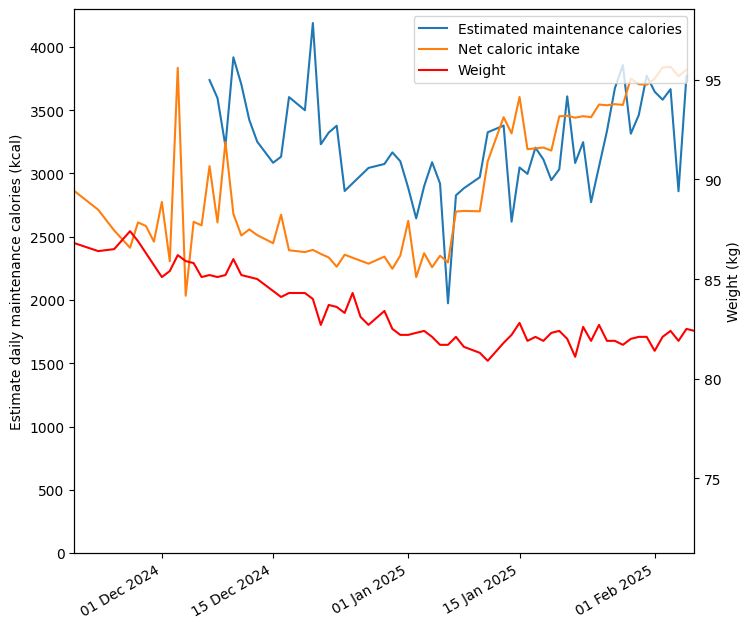

In [122]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

results_clean = results.dropna()
rolling_mean_window = 14
rolling_mean_maintenance = results_clean['cal_maintenance'].rolling(window=rolling_mean_window, center=False).mean()
ln1 = ax1.plot(results_clean.index, rolling_mean_maintenance, label='Estimated maintenance calories')
ln2 = ax1.plot(results_clean.index,results_clean['net_cals'], label='Net caloric intake')
ln3 = ax2.plot(weight_df.index,weight_df['weight'], 'r', label='Weight')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

ax1.set_xlim([min(results_clean.index), max(weight_df.index)])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.gcf().autofmt_xdate()

ax1.set_ylabel("Estimate daily maintenance calories (kcal)")
ax2.set_ylabel("Weight (kg)")

ax1.axis([None,None,0,None])

display(rolling_mean_maintenance)
estimated_maintenance = rolling_mean_maintenance.iloc[-1]

plt.savefig(rf'{results_directory}\figures\maintenance.png', dpi=300, bbox_inches='tight')

In [123]:
print(f"To gain 1 kg/month, need to have {kcal_per_kg} kcal surplus in that month")
print(f"Need {kcal_per_kg/30.43:.1f} kcal surplus per day")
print(f"{estimated_maintenance:.1f} kcal is estimated current maintenance")
print(f"{estimated_maintenance + (kcal_per_kg / 30.43):.1f} kcal is estimated bulk")

To gain 1 kg/month, need to have 7740 kcal surplus in that month
Need 254.4 kcal surplus per day
3771.2 kcal is estimated current maintenance
4025.6 kcal is estimated bulk
